In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import random
import warnings; warnings.simplefilter('ignore')

In [2]:
def SubOptimal(eps,m,p_eps1):
    k = 2
    
    tild_sensitivity = np.zeros(k+1)
    for j in range(1,k+1):
        tild_sensitivity[j] = 2/(m[j]+1)
        
    b = np.zeros(k+1)
    for j in range(1,k+1):
        A = tild_sensitivity[j]*(math.exp(eps[j])*(math.exp(m[j]*eps[j])-1)/(math.exp(eps[j])-1))
        B = (1 + m[j]*tild_sensitivity[j])*math.exp((m[j]+1)*eps[j])
        U = eps[j]/math.log((A + math.sqrt(A**2 + 4*B))/2)
        b[j] = ((m[j]+3)/(m[j]+4))*U
        
    X = np.zeros(k+1)
    Y = np.zeros((k+1,max(m)+2))
    for j in range(1,k+1):
        q = (math.exp(eps[j]/b[j])/(2*((math.exp(eps[j]/b[j])+1)**2)*(math.exp(eps[j])-1)))*((math.exp(eps[j])-1)*(math.exp((m[j]+1)*eps[j])-1)-tild_sensitivity[j]*(math.exp(eps[j])/math.exp(eps[j]/b[j]))*(m[j]*math.exp((m[j]+1)*eps[j])-(m[j]+1)*math.exp(m[j]*eps[j])+1))
        X[j] = math.exp((m[j]+1)*eps[j])/(2*q*(math.exp(eps[j]/b[j])+1))
        for i in range(1,m[j]+2):
            Y[j][i] = (1/(2*q))*(math.exp(eps[j]/b[j])/(math.exp(eps[j]/b[j])+1))*(1+tild_sensitivity[j]*(math.exp(eps[j])/math.exp(eps[j]/b[j]))*((m[j]+1-i)*math.exp(m[j]*eps[j])-(math.exp(m[j]*eps[j])-1)/(math.exp(eps[j])-1)))
        
    d = np.zeros((k+1,max(m)+2))
    for j in range(1,k+1):
        d[j][0] = 2*X[j]
        for i in range(1,m[j]+1):
            d[j][i] = 2*(Y[j][i]-Y[j][i+1])
        d[j][m[j]+1] = 2*Y[j][m[j]+1]
    #print(d)
    
    N = np.zeros((m[1]+2,m[2]+2))
    for i in range(m[1]+2):
        for j in range(m[2]+2):
            N[i][j] = d[1][i]*d[2][j]
    #print(N)
    
    p0 = np.ones(2*m[1]+2*m[2]+5)*(1/(2*m[1]+2*m[2]+4))
    p0[2*m[1]+2*m[2]+4] = math.exp(np.sum(eps))
    fun = lambda p: p[2*m[1]+2*m[2]+4]
    
    cons = ()
    cons = cons + ({'type': 'eq', 'fun': lambda p: np.sum(p[i] for i in range(2*m[1]+2*m[2]+4)) + np.sum(p[m[1]+j]*(N[m[1]-i][j]/N[m[1]][j])*(1/math.exp(p_eps1*i)) for i in range(1,m[1]+1) for j in range(m[2])) - 1},)
    cons = cons + ({'type': 'eq', 'fun': lambda p: p[0] + p[m[1]+m[2]+1] + np.sum(p[m[1]+j]*(N[0][j]/N[m[1]][j])*(1/math.exp(p_eps1*m[1])) for j in range(m[2])) - 1/(math.exp(eps[1]/b[1])+1)},)
    for i in range(1,m[1]):
        cons = cons + ({'type': 'eq', 'fun': lambda p, i=i: p[i] + p[m[1]+m[2]+1+i] + np.sum(p[m[1]+j]*(N[i][j]/N[m[1]][j])*(1/math.exp(p_eps1*(m[1]-i))) for j in range(m[2])) - tild_sensitivity[1]*(math.exp(i*eps[1])/(math.exp(eps[1]/b[1])+1))},)
    cons = cons + ({'type': 'eq', 'fun': lambda p: np.sum(p[i] for i in range(m[1],m[1]+m[2]+1)) + p[2*m[1]+m[2]+1] - tild_sensitivity[1]*(math.exp(m[1]*eps[1])/(math.exp(eps[1]/b[1])+1))},)
    cons = cons + ({'type': 'eq', 'fun': lambda p: np.sum(p[m[1]]*(N[i][0]/N[m[1]][0])*(1/math.exp(p_eps1*(m[1]-i))) for i in range(m[1]+1)) + p[2*m[1]+m[2]+2] - 1/(math.exp(eps[2]/b[2])+1)},)
    for j in range(1,m[2]):
        cons = cons + ({'type': 'eq', 'fun': lambda p, j=j: np.sum(p[m[1]+j]*(N[i][j]/N[m[1]][j])*(1/math.exp(p_eps1*(m[1]-i))) for i in range(m[1]+1)) + p[2*m[1]+m[2]+2+j] - tild_sensitivity[2]*(math.exp(j*eps[2])/(math.exp(eps[2]/b[2])+1))},)
    cons = cons + ({'type': 'eq', 'fun': lambda p: np.sum(p[i] for i in range(m[1])) + p[m[1]+m[2]] + p[2*m[1]+2*m[2]+2] - tild_sensitivity[2]*(math.exp(m[2]*eps[2])/(math.exp(eps[2]/b[2])+1))},)
    
    for i in range(m[1]):
        cons = cons + ({'type': 'ineq', 'fun': lambda p, i=i: (p[i]/N[i][m[2]]) - (p[m[1]+m[2]-1]/N[m[1]][m[2]-1])*(1/math.exp(p_eps1*(m[1]-i)))},)
        cons = cons + ({'type': 'ineq', 'fun': lambda p, i=i: (p[m[1]+m[2]+1+i]/N[i][m[2]+1]) - (p[i]/N[i][m[2]])},)
    for i in range(m[1]-1):
        cons = cons + ({'type': 'ineq', 'fun': lambda p, i=i: (p[i+1]/N[i+1][m[2]]) - (p[i]/N[i][m[2]])},)
        cons = cons + ({'type': 'ineq', 'fun': lambda p, i=i: (p[m[1]+m[2]+2+i]/N[i+1][m[2]+1]) - (p[m[1]+m[2]+1+i]/N[i][m[2]+1])},)
    cons = cons + ({'type': 'ineq', 'fun': lambda p: (p[m[1]+m[2]]/N[m[1]][m[2]]) - (p[m[1]-1]/N[m[1]-1][m[2]])},)
    cons = cons + ({'type': 'ineq', 'fun': lambda p: (p[2*m[1]+m[2]+1]/N[m[1]][m[2]+1]) - (p[2*m[1]+m[2]]/N[m[1]-1][m[2]+1])},)
    for j in range(m[2]):
        cons = cons + ({'type': 'ineq', 'fun': lambda p, j=j: (p[m[1]+j+1]/N[m[1]][j+1]) - (p[m[1]+j]/N[m[1]][j])},)
        cons = cons + ({'type': 'ineq', 'fun': lambda p, j=j: (p[2*m[1]+m[2]+3+j]/N[m[1]+1][j+1]) - (p[2*m[1]+m[2]+2+j]/N[m[1]+1][j])},)
        cons = cons + ({'type': 'ineq', 'fun': lambda p, j=j: (p[2*m[1]+m[2]+2+j]/N[m[1]+1][j]) - (p[m[1]+j]/N[m[1]][j])},)
    cons = cons + ({'type': 'ineq', 'fun': lambda p: (p[2*m[1]+m[2]+1]/N[m[1]][m[2]+1]) - (p[m[1]+m[2]]/N[m[1]][m[2]])},)
    cons = cons + ({'type': 'ineq', 'fun': lambda p: (p[2*m[1]+2*m[2]+2]/N[m[1]+1][m[2]]) - (p[m[1]+m[2]]/N[m[1]][m[2]])},)
    cons = cons + ({'type': 'ineq', 'fun': lambda p: (p[2*m[1]+2*m[2]+3]/N[m[1]+1][m[2]+1]) - (p[2*m[1]+m[2]+1]/N[m[1]][m[2]+1])},)
    cons = cons + ({'type': 'ineq', 'fun': lambda p: (p[2*m[1]+2*m[2]+3]/N[m[1]+1][m[2]+1]) - (p[2*m[1]+2*m[2]+2]/N[m[1]+1][m[2]])},)
    
    for i in range(m[1]-1):
        cons = cons + ({'type': 'ineq', 'fun': lambda p, i=i: p[2*m[1]+2*m[2]+4] - math.exp(p_eps1*(m[1]-i))*((p[i+1]/N[i+1][m[2]])/(p[m[1]+m[2]-1]/N[m[1]][m[2]-1]))},)
        cons = cons + ({'type': 'ineq', 'fun': lambda p, i=i: p[2*m[1]+2*m[2]+4] - (p[m[1]+m[2]+2+i]/N[i+1][m[2]+1])/(p[i]/N[i][m[2]])},)
    for j in range(m[2]):
        cons = cons + ({'type': 'ineq', 'fun': lambda p, j=j: p[2*m[1]+2*m[2]+4] - math.exp(p_eps1)*((p[m[1]+j+1]/N[m[1]][j+1])/(p[m[1]+j]/N[m[1]][j]))},)
        cons = cons + ({'type': 'ineq', 'fun': lambda p, j=j: p[2*m[1]+2*m[2]+4] - (p[2*m[1]+m[2]+3+j]/N[m[1]+1][j+1])/(p[m[1]+j]/N[m[1]][j])},)
    cons = cons + ({'type': 'ineq', 'fun': lambda p: p[2*m[1]+2*m[2]+4] - (p[2*m[1]+m[2]+1]/N[m[1]][m[2]+1])/(p[m[1]-1]/N[m[1]-1][m[2]])},)
    cons = cons + ({'type': 'ineq', 'fun': lambda p: p[2*m[1]+2*m[2]+4] - (p[2*m[1]+2*m[2]+3]/N[m[1]+1][m[2]+1])/(p[m[1]+m[2]]/N[m[1]][m[2]])},)
        
    
    bnds = [(0,1)]*(2*m[1]+2*m[2]+5)
    bnds[2*m[1]+2*m[2]+4] = (0,np.inf)
    
    res = minimize(fun, p0, bounds=bnds, constraints=cons)
    if res.message == 'Inequality constraints incompatible' or res.fun < math.exp(p_eps1):
        return math.exp(np.sum(eps)), [100,100]
    else:
        return res.fun, res.x

In [3]:
def evaluation(k):
    k = 2
    aeps = [2, 2.5, 3, 3.5, 4, 4.5, 5]
    s = np.zeros(7); p = np.zeros((7,2)); r = 50
    
    eps = np.zeros(k+1); m = [0,5,5]
    for i in range(7):
        s[i] = aeps[i]*k
        for j in range(r):
            for l in range(1,k+1):
                eps[l] = random.random()
            eps = [eps[l]*s[i]/(sum(eps)) for l in range(k+1)]
            p[i][0] += 1
            privacy = s[i]
            for J in range(21):
                p_eps1 = eps[1]*(80+J)*0.01
                M = SubOptimal(eps,m,p_eps1)
                if M[1][0] != 100:
                    privacy = min(privacy,math.log(M[0]))
            p[i][1] += privacy/s[i]
        p[i][0] /= r
        p[i][1] /= r
    
    return p

[[1.         0.91315894]
 [1.         0.88959902]
 [1.         0.90740127]
 [1.         0.91195717]
 [1.         0.89430504]
 [1.         0.89792065]
 [1.         0.90700388]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


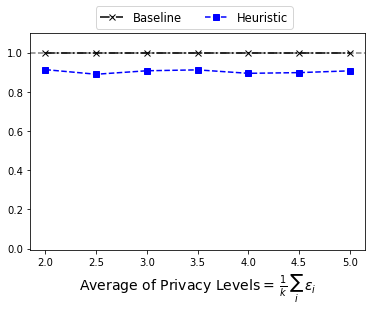

In [4]:
k = 2
p = evaluation(k)
print(p)

s = [2, 2.5, 3, 3.5, 4, 4.5, 5]

fig = plt.figure()
plt.ylim(-0.01, 1.1)
plt.axhline(1, ls="--",color="gray")
plt.plot(s,p[:,0],marker="x",color="black",linestyle = "dashdot",label="Baseline")
plt.plot(s,p[:,1],marker="s",color="blue",linestyle = "dashed",label="Heuristic")
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=3, fontsize=11.5)
plt.xlabel("Average of Privacy Levels" r"$= \, \frac{1}{k} \, \sum_i \, \epsilon_i$",fontsize=14)
fig.savefig("Privacy_Heuristic_k=2.png")
fig.savefig("figs/Privacy_Heuristic_k=2.eps", bbox_inches="tight", pad_inches=0.05)